[INFO] Klassenverhältnis: [2373  627]
[TUNING] Bester Schwellenwert (Val, max F1): 0.545

== Logistische Regression – Standard (0.5) ==
Treffergenauigkeit: 0.905
Ausgewogene Treffergenauigkeit: 0.905
Präzision: 0.715
Trefferquote: 0.904
F1: 0.799
Brier-Wert: 0.082
Fläche unter Treffer-Fehlalarm-Kennlinie: 0.933
Fläche unter Präzision-Erinnerung-Kennlinie: 0.844

== Logistische Regression – Getunter Schwellenwert ==
Treffergenauigkeit: 0.908
Ausgewogene Treffergenauigkeit: 0.895
Präzision: 0.736
Trefferquote: 0.872
F1: 0.799
Brier-Wert: 0.082
Fläche unter Treffer-Fehlalarm-Kennlinie: 0.933
Fläche unter Präzision-Erinnerung-Kennlinie: 0.844


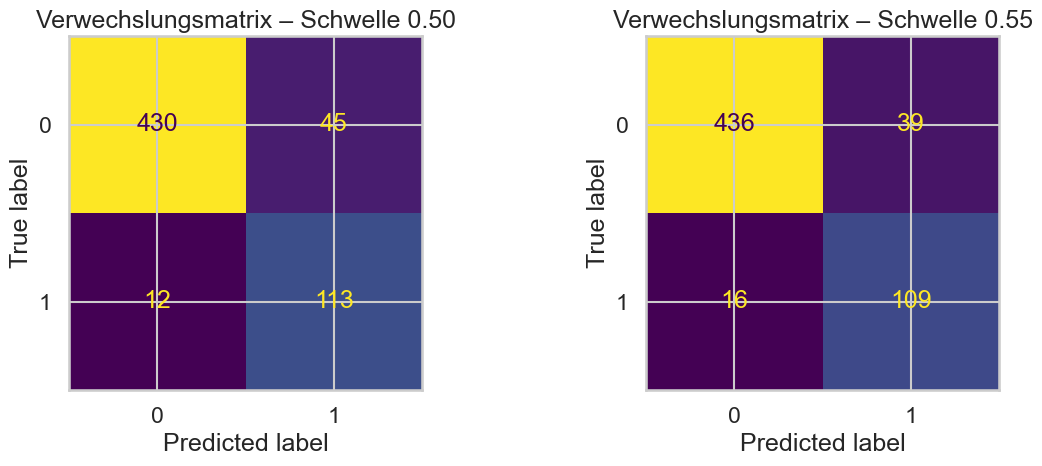

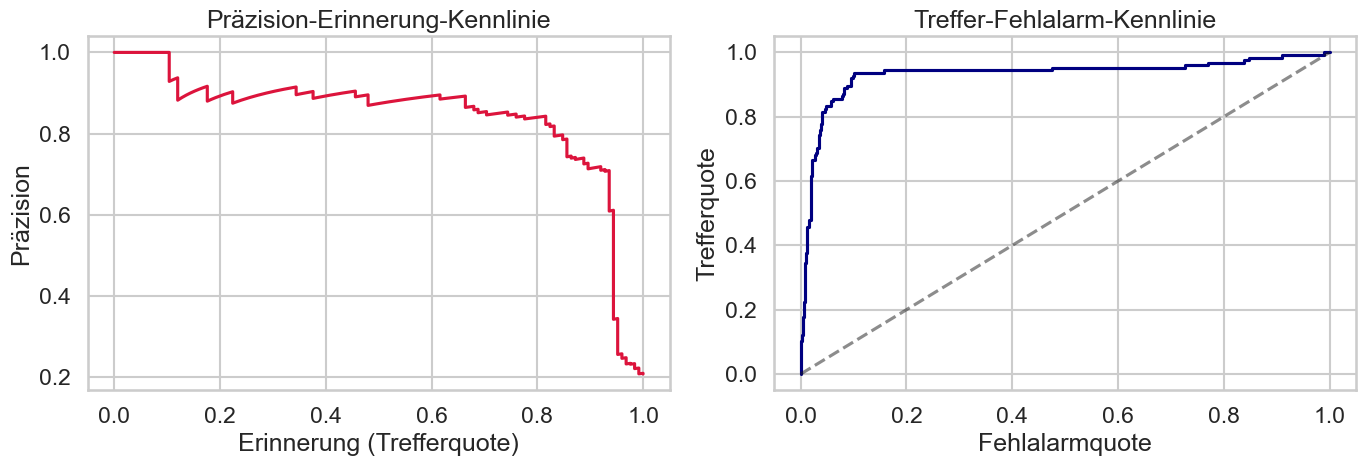

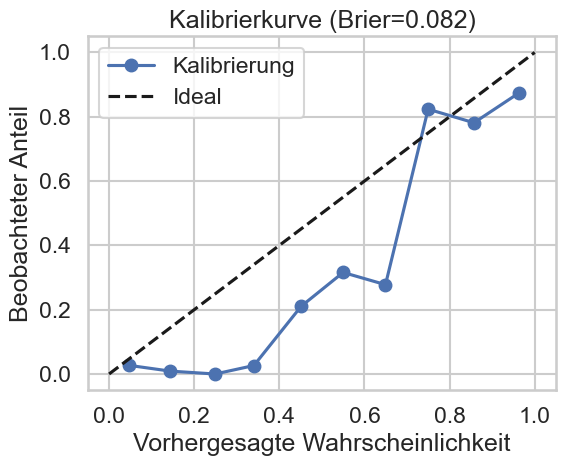

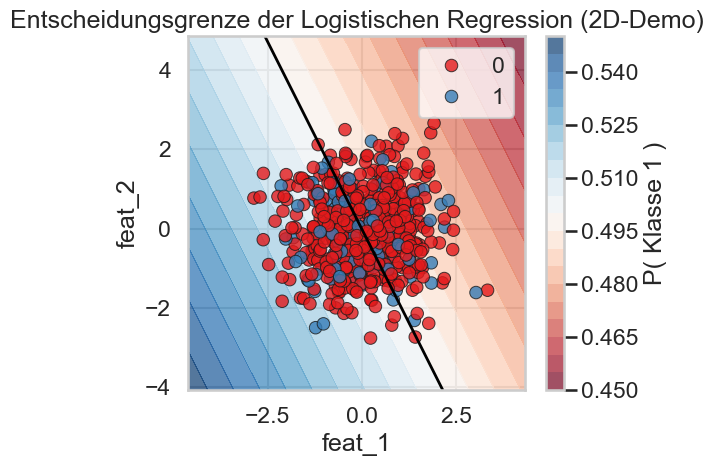


== Wald-Ansammlung – gleicher Schwellenwert ==
Treffergenauigkeit: 0.973
Ausgewogene Treffergenauigkeit: 0.96
Präzision: 0.936
Trefferquote: 0.936
F1: 0.936
Brier-Wert: 0.026
Fläche unter Treffer-Fehlalarm-Kennlinie: 0.962
Fläche unter Präzision-Erinnerung-Kennlinie: 0.948


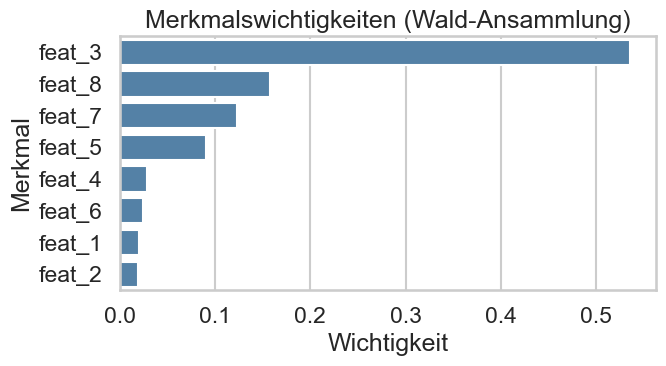


Fertig: Wahrscheinlichkeitsmodell, Schwellenwertwahl, faire Metriken, Kalibrierung, Umgang mit Klassenungleichgewicht und Vergleich linear vs. nichtlinear.


In [4]:
"""
Vorlesung 6 – Klassifikation mit Wahrscheinlichkeiten:
- Synthetische, unausgewogene Binärdaten mit 2 informativen + Rauschmerkmalen
- Train/Val/Test-Split ohne Leckagen
- Pipeline: Skalierung + Logistische Regression (mit Regularisierung, Klassengewichten)
- Visualisierungen: 2D-Entscheidungsgrenze (Demo auf 2 Features), Verwechslungsmatrix, Kennlinien,
  Kalibrierkurve, Brier-Wert, Feature-"Wichtigkeiten" (Koeffizienten), Vergleich mit Wald-Ansammlung
- Schwellenwert-Tuning auf Validierungsdaten (Maximierung F1), finale Bewertung auf Test

Benötigt: numpy, pandas, seaborn, matplotlib, scikit-learn
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve,
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    brier_score_loss, average_precision_score, roc_auc_score
)
from sklearn.calibration import calibration_curve

sns.set_theme(style="whitegrid", context="talk")
rng = np.random.RandomState(7)

# ------------------------------------------------------------
# 0) Daten erzeugen: unausgewogen, mäßig überlappende Klassen
# ------------------------------------------------------------
X, y = make_classification(
    n_samples=3000, n_features=8, n_informative=2, n_redundant=2, n_repeated=0,
    n_clusters_per_class=2, weights=[0.8, 0.2], class_sep=1.2, flip_y=0.03,
    random_state=7
)
feature_names = [f"feat_{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

print("[INFO] Klassenverhältnis:", np.bincount(y))

# ------------------------------------------------------------
# 1) Aufteilen: Train (60%), Val (20%), Test (20%)
# ------------------------------------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
# -> 0.6 / 0.2 / 0.2

# ------------------------------------------------------------
# 2) Pipeline: Skalierung + Logistische Regression (mit Klassengewicht)
# ------------------------------------------------------------
logit_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2", C=1.0, solver="lbfgs", max_iter=200,
        class_weight="balanced", random_state=42
    ))
])
logit_pipe.fit(X_train, y_train)

# Wahrscheinlichkeiten
p_val = logit_pipe.predict_proba(X_val)[:, 1]
p_test = logit_pipe.predict_proba(X_test)[:, 1]

# ------------------------------------------------------------
# 3) Schwellenwert-Tuning auf Val: F1 maximieren
# ------------------------------------------------------------
prec, rec, thr = precision_recall_curve(y_val, p_val)
f1_vals = 2 * (prec * rec) / np.maximum(prec + rec, 1e-12)
best_idx = np.nanargmax(f1_vals)
best_thr = thr[max(0, best_idx-1)] if best_idx < len(thr) else 0.5  # robuster Zugriff
print(f"[TUNING] Bester Schwellenwert (Val, max F1): {best_thr:.3f}")

# Vorhersage auf Test: Standard (0.5) vs getuned
yhat_test_default = (p_test >= 0.5).astype(int)
yhat_test_tuned   = (p_test >= best_thr).astype(int)

# ------------------------------------------------------------
# 4) Metriken berichten (Test)
# ------------------------------------------------------------
def report(name, y_true, y_pred, p_prob):
    print(f"\n== {name} ==")
    print("Treffergenauigkeit:", round(accuracy_score(y_true, y_pred), 3))
    print("Ausgewogene Treffergenauigkeit:", round(balanced_accuracy_score(y_true, y_pred), 3))
    print("Präzision:", round(precision_score(y_true, y_pred), 3))
    print("Trefferquote:", round(recall_score(y_true, y_pred), 3))
    print("F1:", round(f1_score(y_true, y_pred), 3))
    print("Brier-Wert:", round(brier_score_loss(y_true, p_prob), 3))
    print("Fläche unter Treffer-Fehlalarm-Kennlinie:", round(roc_auc_score(y_true, p_prob), 3))
    print("Fläche unter Präzision-Erinnerung-Kennlinie:", round(average_precision_score(y_true, p_prob), 3))

report("Logistische Regression – Standard (0.5)", y_test, yhat_test_default, p_test)
report("Logistische Regression – Getunter Schwellenwert", y_test, yhat_test_tuned, p_test)

# ------------------------------------------------------------
# 5) Verwechslungsmatrizen (Test)
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_test_default)).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Verwechslungsmatrix – Schwelle 0.50")
ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_test_tuned)).plot(ax=ax[1], colorbar=False)
ax[1].set_title(f"Verwechslungsmatrix – Schwelle {best_thr:.2f}")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 6) Kennlinien: Präzision-Erinnerung und Treffer-Fehlalarm
# ------------------------------------------------------------
prec_t, rec_t, _ = precision_recall_curve(y_test, p_test)
fa_rate, tr_rate, _ = roc_curve(y_test, p_test)  # fa_rate = false positive rate, tr_rate = true positive rate

fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(rec_t, prec_t, color="crimson")
ax[0].set_xlabel("Erinnerung (Trefferquote)")
ax[0].set_ylabel("Präzision")
ax[0].set_title("Präzision-Erinnerung-Kennlinie")
ax[0].grid(True)

ax[1].plot(fa_rate, tr_rate, color="navy")
ax[1].plot([0,1],[0,1],"k--", alpha=0.5)
ax[1].set_xlabel("Fehlalarmquote")
ax[1].set_ylabel("Trefferquote")
ax[1].set_title("Treffer-Fehlalarm-Kennlinie")
ax[1].grid(True)
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 7) Kalibrierung: Kalibrierkurve + Brier-Wert
# ------------------------------------------------------------
prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label="Kalibrierung")
plt.plot([0,1],[0,1],"k--", label="Ideal")
plt.xlabel("Vorhergesagte Wahrscheinlichkeit")
plt.ylabel("Beobachteter Anteil")
plt.title(f"Kalibrierkurve (Brier={brier_score_loss(y_test, p_test):.3f})")
plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 8) Entscheidungsgrenze in 2D (nur Demo mit 2 Features)
# ------------------------------------------------------------
# Für die Visualisierung trainieren wir eine 2D-Variante auf den ersten zwei Features:
pipe_2d = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(class_weight="balanced", random_state=42))
]).fit(X_train[:, :2], y_train)

xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-1, X[:,0].max()+1, 300),
    np.linspace(X[:,1].min()-1, X[:,1].max()+1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
probs_grid = pipe_2d.predict_proba(grid)[:,1].reshape(xx.shape)

plt.figure(figsize=(6,5))
cs = plt.contourf(xx, yy, probs_grid, levels=20, cmap="RdBu", alpha=0.7)
plt.colorbar(cs, label="P( Klasse 1 )")
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, palette="Set1", edgecolor="k", alpha=0.8)
plt.contour(xx, yy, probs_grid, levels=[0.5], colors="black", linewidths=2)
plt.title("Entscheidungsgrenze der Logistischen Regression (2D-Demo)")
plt.xlabel("feat_1"); plt.ylabel("feat_2")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 9) Vergleich: Wald-Ansammlung (nichtlinear), gleiche Splits
# ------------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_leaf=2,
    class_weight="balanced_subsample", random_state=42, n_jobs=-1
).fit(X_train, y_train)

rf_p_test = rf.predict_proba(X_test)[:,1]
rf_yhat = (rf_p_test >= best_thr).astype(int)  # gleicher Schwellenwert, für Vergleich

report("Wald-Ansammlung – gleicher Schwellenwert", y_test, rf_yhat, rf_p_test)

# Wichtigkeiten (nach Impurität) – nur zur Orientierung:
imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=imp.values, y=imp.index, color="steelblue")
plt.title("Merkmalswichtigkeiten (Wald-Ansammlung)")
plt.xlabel("Wichtigkeit"); plt.ylabel("Merkmal")
plt.tight_layout(); plt.show()

print("\nFertig: Wahrscheinlichkeitsmodell, Schwellenwertwahl, faire Metriken, Kalibrierung, Umgang mit Klassenungleichgewicht und Vergleich linear vs. nichtlinear.")
